In [3]:
import torch
from torch_geometric import datasets
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
import matplotlib.pyplot as plt
from tqdm import tqdm

from losses import kl_div_vmf, reconstruction_loss
from train_utils import get_edge_probs
from models import VGAE
from sklearn.metrics import roc_auc_score, average_precision_score

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = datasets.Planetoid(root='/__data/Cora', name='Cora', split='public')

In [6]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [7]:
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False) # because we perform negative sampling at each epoch ourselves

In [8]:
train_data, val_data, test_data = transform(dataset[0])

In [9]:
print('train data', train_data)
print('val data', val_data)
print('test data', test_data)

print(dataset[0].edge_index.shape[1])
print(train_data.pos_edge_label.size(0)*2 + val_data.pos_edge_label.size(0) + val_data.neg_edge_label.size(0) + test_data.pos_edge_label.size(0) + test_data.neg_edge_label.size(0))

train data Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])
val data Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263])
test data Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])
10556
10556


In [10]:
# train_data['neg_edge_label_index'] = negative_sampling(train_data.pos_edge_label_index)

In [11]:
feature_dim = dataset[0].x.shape[1]
print('input dim', feature_dim)

input dim 1433


## Check model forward pass

In [12]:
val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)
val_edge_label_index.shape

torch.Size([2, 526])

In [13]:
n_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='normal').to(device)

out_n_vgae, mus_n_vgae, logsigmas2s_n_vgae  = n_vgae(val_data.x.to(device), val_edge_label_index.to(device))
print('out', out_n_vgae.shape)
print('mus', mus_n_vgae.shape)
print('logsigmas2s', logsigmas2s_n_vgae.shape)
labs, edge_probs = get_edge_probs(out_n_vgae, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
print('edge probs', len(edge_probs)==len(labs))

out torch.Size([2708, 2708])
mus torch.Size([2708, 16])
logsigmas2s torch.Size([2708, 16])
edge probs True


In [14]:
s_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='vMF').to(device)


out_s_vgae, mus_s_vgae, logkappas_s_vgae, ws, epss, bs = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
print('out', out_s_vgae.shape)
print('mus', mus_s_vgae.shape)
print('logkappas', logkappas_s_vgae.shape)
print('ws', ws.shape)
print('epss', epss.shape)
print('bs', bs.shape)
labs, edge_probs = get_edge_probs(out_s_vgae, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
print('edge probs', len(edge_probs)==len(labs))

out torch.Size([2708, 2708])
mus torch.Size([2708, 16])
logkappas torch.Size([2708])
ws torch.Size([2708])
epss torch.Size([2708])
bs torch.Size([2708])
edge probs True


In [15]:
num_epochs = 200
lr = 0.01
optimizer = torch.optim.Adam(s_vgae.parameters(), lr=lr)

## Train $\mathcal{S}$-VGAE

In [16]:
log_loss = {'train': [] }
log_metrics = {'val_auc' : [],
               'val_ap' : []}
val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)

for epoch in range(num_epochs):

    # negative sampling 
    train_neg_edge_index = negative_sampling(train_data.pos_edge_label_index)
    train_data['edge_label_index'] = torch.cat([train_data.pos_edge_label_index, train_neg_edge_index], dim=1)


    kl = kl_div_vmf.apply
    
    optimizer.zero_grad()
    
    output, mus, logkappas, ws, epss, bs = s_vgae(train_data.x.to(device), train_data.edge_label_index.to(device) )
    kappas = torch.exp(logkappas)

    print('kappa', kappas)
    kl_loss = kl(kappas, mus) 
    loss_recon = reconstruction_loss(output, train_data.pos_edge_label_index, train_neg_edge_index)
    loss = loss_recon + kl_loss
    print('loss_recon', loss_recon)  
    print('kl_loss', kl_loss)
    # print('loss', loss)
    
    loss.backward()

    optimizer.step()

    with torch.no_grad():
        log_loss['train'].append(loss.item())
        if epoch % 5 == 0:
            out_val, mus_val, logkappas_val, ws, epss, bs = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
            val_labs, edge_probs_val = get_edge_probs(out_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
            log_metrics['val_auc'].append(roc_auc_score(val_labs, edge_probs_val))
            log_metrics['val_ap'].append(average_precision_score(val_labs, edge_probs_val))
        

        if epoch % 10 == 0:
            print('Epoch: {:3d}, VAL AUC: {:.4f}'.format(epoch, log_metrics['val_auc'][-1]))
            print(f'Epoch {epoch:3d}, TRAIN LOSS: {loss.item():.4f}')


loss_recon tensor(7146.7388, grad_fn=<NegBackward0>)
kl_loss tensor(-5276.0596, grad_fn=<kl_div_vmfBackward>)
Epoch:   0, VAL AUC: 0.5238
Epoch   0, TRAIN LOSS: 1870.6792
loss_recon tensor(7261.5425, grad_fn=<NegBackward0>)
kl_loss tensor(-22165.7461, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7048.7354, grad_fn=<NegBackward0>)
kl_loss tensor(-38206.8281, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7198.1113, grad_fn=<NegBackward0>)
kl_loss tensor(-51921.5352, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7095.3247, grad_fn=<NegBackward0>)
kl_loss tensor(-63185.2188, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7191.2954, grad_fn=<NegBackward0>)
kl_loss tensor(-75338.8828, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7168.1729, grad_fn=<NegBackward0>)
kl_loss tensor(-84302.8750, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7172.1758, grad_fn=<NegBackward0>)
kl_loss tensor(-91650.3359, grad_fn=<kl_div_vmfBackward>)
loss_recon tensor(7100.4448, grad_fn=<NegBackward0>)

In [17]:
def plot_curves(log_loss):
    fig, ax = plt.subplots()

    ax.plot(log_loss['train'], label='train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Learning curves')

    plt.show()  
    

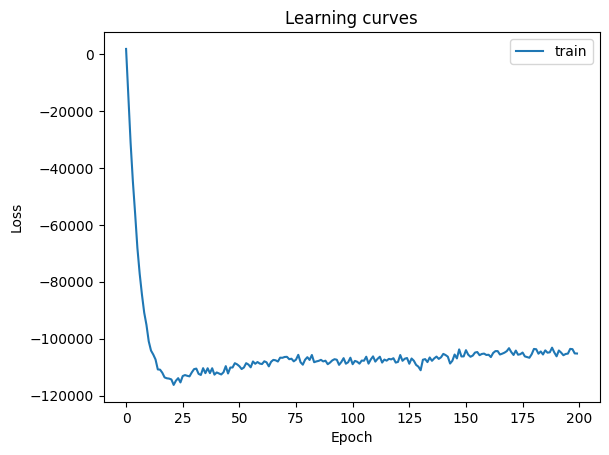

In [18]:
plot_curves(log_loss)

In [ ]:
import pickle
with open('results/loss_train.pkl', 'wb') as f:
    pickle.dump(log_loss, f)

with open('results/log_metrics.pkl', 'wb') as f:
    pickle.dump(log_metrics, f)

## Grid search 
as done in the article 

In [ ]:
from itertools import product
from pathlib import Path
import pickle

latent_dim = [8, 16, 32]
learning_rates = [.01, .005, .001]

results = Path('results')

In [ ]:
for d, lr in product(latent_dim, learning_rates):
    metrics =  {
        'train_loss' : [],
        'val_auc' : [],
        'val_ap' : []
    }

    val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)

    for epoch in range(num_epochs):

        # negative sampling 
        train_neg_edge_index = negative_sampling(train_data.pos_edge_label_index)
        train_data['edge_label_index'] = torch.cat([train_data.pos_edge_label_index, train_neg_edge_index], dim=1)

        kl = kl_div_vmf.apply
        
        optimizer.zero_grad()
        
        output, mus, logkappas, ws, epss, bs = s_vgae(train_data.x.to(device), train_data.edge_label_index.to(device) )
        kappas = torch.exp(logkappas)
        kl_loss = kl(kappas, mus) 
        loss_recon = reconstruction_loss(output, train_data.pos_edge_label_index, train_neg_edge_index)
        loss = loss_recon + kl_loss
        # print('loss_recon', loss_recon)  
        # print('kl_loss', kl_loss)
        # print('loss', loss)
        
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            metrics['train_loss'].append(loss.item())

            out_val, mus_val, logkappas_val, ws, epss, bs = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
            val_labs, edge_probs_val = get_edge_probs(out_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
            metrics['val_auc'].append(roc_auc_score(val_labs, edge_probs_val))
            metrics['val_ap'].append(average_precision_score(val_labs, edge_probs_val))
            
            if epoch % 10 == 0:
                print('Epoch: {:3d}, VAL AUC: {:.4f}'.format(epoch, log_metrics['val_auc'][-1]))
                print(f'Epoch {epoch:3d}, TRAIN LOSS: {loss.item():.4f}')


with open(results / f's_vgae_dim{d}_lr{lr}.pkl', 'wb') as f:
    pickle.dump(metrics, f)
